## Stable Diffusion fine tune with DreamBooth on SageMaker g4dn notebook
* Tested with ml.g4dn.2xlarge SageMaker notebook, which has a NVIDIA T4 GPU with 16 GiB GPU memory.
* leverage codes from [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)

### 1. Install dependencies

In [1]:
%%writefile requirements.txt
accelerate
torchvision==0.14.0
transformers>=4.21.0"
ftfy
tensorboard
modelcards
natsort

Writing requirements.txt


In [2]:
!pip install -U pip
!pip install -U torch==1.13.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/ShivamShrirao/diffusers.git
!pip install -U -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/ShivamShrirao/diffusers.git to /tmp/pip-req-build-z12e7wta
  Running command git clone --filter=blob:none --quiet https://github.com/ShivamShrirao/diffusers.git /tmp/pip-req-build-z12e7wta
  Resolved https://github.com/ShivamShrirao/diffusers.git to commit 862e42692912157ba8ebd16e48417444a60a6192
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### 2. Install GPU memory optimization libraries

In [3]:
!pip install bitsandbytes==0.35.4 # newly updated version of bitsandbytes made images garbage, so fix the version

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
!pip install -U triton
!pip install https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 44.7 MB/s eta 0:00:0000:0100:01


### 3. Initialize an Accelerate environment 

In [5]:
from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /home/ec2-user/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

### 4. Get training scripts from ShivamShrirao's repo

In [6]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py

### 5. Train a modle for generating a person in cyberpunk style  
* "style" training example, you can also train the model for "object" or "person"  
* More information you can refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)

In [7]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/source"
CLASS_DATA_DIR = "images/class"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $CLASS_DATA_DIR

In [8]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/source/* $INSTANCE_DATA_DIR
# you can generate your own class images during training
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/class/* $CLASS_DATA_DIR 

Cloning into 'dreambooth-stablediffusion-sagemaker-notebook'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 233 (delta 12), reused 229 (delta 8), pack-reused 0
Receiving objects: 100% (233/233), 11.36 MiB | 57.04 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [9]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of cypk style" \
  --class_prompt="photo of style" \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=1000 \
  # --save_interval=500 \
  # --sample_batch_size=2 \
  # --save_sample_prompt="photo of cypk style man" 

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)
Fetching 15 files: 100%|█████████████████████| 15/15 [00:00<00:00, 28200.16it/s]
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon

### 6. Mode inference testing

In [10]:
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")    

[*] WEIGHTS_DIR=stable_diffusion_weights/dreambooth_fine_tune/1000


  0%|          | 0/20 [00:00<?, ?it/s]

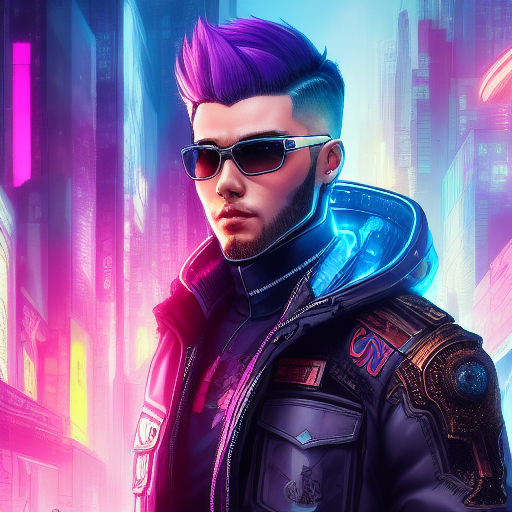

  0%|          | 0/20 [00:00<?, ?it/s]

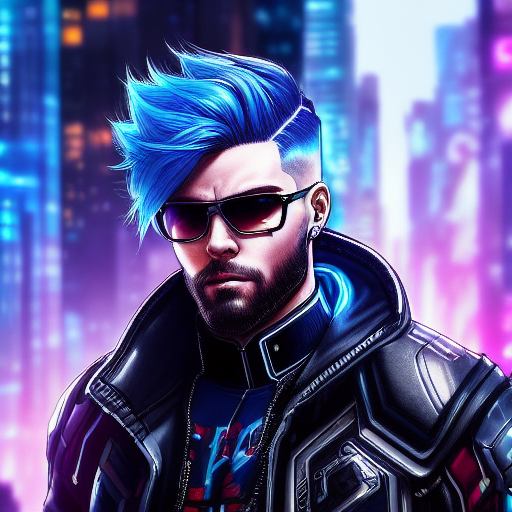


Seeds for generating images: [2652660484899092, 3602547582604926]



In [11]:
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = WEIGHTS_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
prompt = "a photo of cypk style man, handsome detailed face, city background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

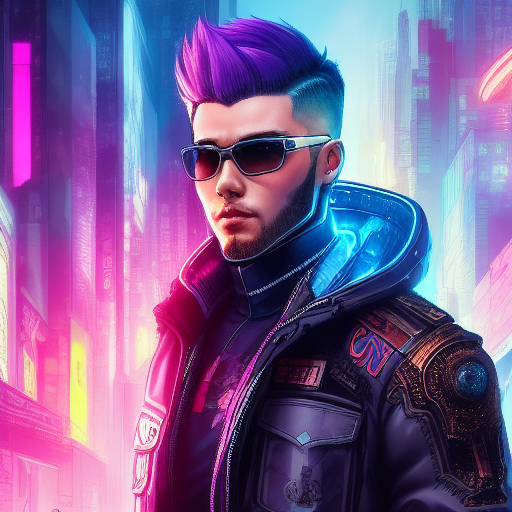

In [12]:
# comment below codes, if you want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

### 7. Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111

In [13]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
ckpt_path = WEIGHTS_DIR + "/model.ckpt"
half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at stable_diffusion_weights/dreambooth_fine_tune/1000/model.ckpt
